## About

The Thomas Fire, which burned over 280,000 acres in Ventura and Santa Barbara counties in December 2017, was one of California’s largest wildfires at the time. It caused widespread ecological damage, displaced communities, and left lasting environmental impacts.

Using NASA's Landsat data and California Fire Perimeter data, I create a map that visualizes the extent of the Thomas Fire. In conjunction, I use Air Quality Index (AQI) data from the Environmental Protection Agency (EPA) to visualize the AQI surrounding the fire. Together, these visualizations showcase the impact that the Thomas Fire had on the community. 

|                                     |                                      |
|-------------------------------------|--------------------------------------|
| <img src="fire-scar.png" width="350"> | <img src="aqi.png" width="450">      |



#### **For the full analysis, see my [GitHub repository](https://github.com/marinakochuten/thomas-fire-analysis).**

### Highlights

- Raster manipulation using `rioxarray`
- Vector data manipulation using `GeoPandas`
- False color imagery to highlight wildfire impact
- Data visualization with `matplotlib`

### Data

**Landsat:** I use a simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. The data was retrieved from the Microsoft Planetary Computer data catalogue and pre-processed to remove data outside land and coarsen the spatial resolution. This data is intended for visualization and educational purposes only.
- *Citation:* Microsoft Planetary Computer data catalogue (2024), *Landsat Collection 2 Level-2 (simplified)* [Data set] Available from: https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Access date: November 18, 2024.

**Fire perimeters:** I use California Fire Perimeter data from the State of California's Data Catalog to subset to the Thomas Fire boundary. In this analysis, I will be using the file that I created from the full dataset. The dataset is updated annually and includes fire perimeters dating back to 1878.
- *Citation:* State of California Data Catalog (2024), California Fire Perimeters (all) [Data set] Available from: https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436. Access date: November 18, 2024.

**Air Quality Index (AQI):** The EPA's AirData tool has pre-generated files of data available for download. The files are updated twice per year: once in June to capture the complete data for the prior year and once in December to capture the data for the summer. AQI is calculated each day for each monitor for the Criteria Gases and PM10 and PM2.5. For this analysis, I use two files, one containing daily AQI data for 2017 and one for 2018.
- *Citation:* Environmental Protection Agency AirData (2024), Daily AQI by County [Data Set] Available from: https://www.epa.gov/outdoor-air-quality-data/download-daily-data. Access date: October 20, 2024.

## Mapping the fire

#### Setup

To start, I set up my analysis by loading all necessary libraries and data files.

In [1]:
# Libraries for general analysis
import numpy as np
import pandas as pd

# Libraries for geospatial data
import geopandas as gpd
import rioxarray as rioxr

# Libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches                # For creating custom legend
from matplotlib_scalebar.scalebar import ScaleBar    # For adding scalebar 

# Import Landsat data
landsat = rioxr.open_rasterio('data/landsat8-2018-01-26-sb-simplified.nc')

# Import California fire perimeters
thomas_fire = gpd.read_file('data/thomas_fire_boundary.geojson')

#### Prepare Data

Now, I need to prepare the Landsat data. For processing the Landsat data, I will be primarily working with the `rioxarray` package. `rioxarray` is an extension of `xarray` that focuses on geospatial raster data. By loading the Landsat data in using `rioxarray`, I load the file as an `xarray.Dataset`, an object that includes both the raster data and the associated geospatial metadata, including CRS, affine transformations, and spatial coordinates.

In [2]:
# Look at the Landsat raster
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

Taking a look at the Landsat raster, I notice that we have a dimension named band that contains only one layer. 

Using `squeeze()` and `drop_vars()`, I drop this unnecessary band dimension and it's associated coordinates, resulting in a simpler, 2-dimensional raster. This will make plotting easier down the line.

In [3]:
# Drop redundant band dimension
landsat = landsat.squeeze().drop_vars('band')

Now, the Landsat raster is ready to be plotted. 

To accentuate the Thomas fire scar, I overlay the Landsat raster with a polygon representing the perimeter of the Thomas Fire. In my full analysis, I prepared the California fire perimeter data by creating a new geospatial object containing only the Thomas Fire perimeter and saved it as `thomas_fire_boundary.geojson`. When manipulating the fire perimeter data, I used `GeoPandas`. Building off of the `pandas.DataFrame`, the core data structure in `GeoPandas` is the `geopandas.GeoDataFrame`, which can store geometry columns and perform spatial operations!

I knew that the California fire perimeter data contains the columns YEAR\_ and FIRE_NAME, which were useful for subsetting to the 2017 Thomas Fire. Since `geopandas.GeoDataFrames` are `pandas.DataFrames` at their core, I used basic dataframe subsetting to pull out the area of interest.

For the purposes of this post, I have only included my subset file. For the full analysis, see [my GitHub repository](https://github.com/marinakochuten/thomas-fire-analysis).

#### Plot the Landsat raster using false color and the Thomas Fire perimeter to highlight the extent of the burn

Remote sensing instruments collect data from wavelengths both within and outside of the visible spectrum. **False color imagery** uses these non-visible wavelengths to reveal unique aspects that may not be visible otherwise. False color imagery has a wide range of applications, including acting as a useful tool for monitoring wildfire impacts. By assigning infrared bands to visible colors, these images highlight vegetation health, burn severity, and the extent of fire scars.

In this case, I use false color imagery to highlight the 2017 Thomas Fire's burn scar. I use Landsat's shortwave infrared as red, near infrared as green, and green bands as blue to visualize the burn. Newly burned land reflects strongly in SWIR bands, making the burn scar appear red in my map. The bright green shows vegetation, as it reflects near infrared light very strongly.

To do so, I select the shortwave infrared, near infrared, and red variables, convert to array, and plot. By setting the parameter `robust = True` in the `imshow()` method, I adjust the display of the image to handle color scaling appropriately by ignoring the outlier RBG values caused by clouds. It fixes contrast issues that cause images to appear bright white.

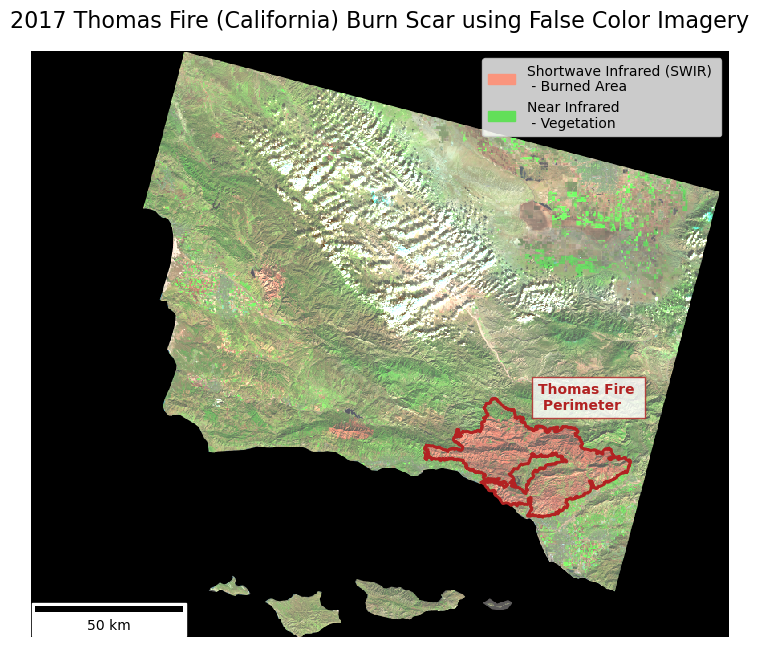

In [4]:
#| code-fold: true
#| code-summary: "Show code for the false color image"

# Before two spatial object can interact, I must match the CRSs
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)
assert thomas_fire.crs == landsat.rio.crs

# Create an object containing the aspect ratio for the landsat map
ratio = landsat.rio.width / landsat.rio.height

# Initialize plot
fig, ax = plt.subplots(figsize = (9, 9 * ratio))  # Update figure size and aspect

# Remove axis for cleaner map
ax.axis('off')

# Plot false color image highlighting the burn scar
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax, zorder = 1)

# Add custom legend items for false color image bands
legend_swir = mpatches.Patch(color = "#FA957D", label = 'Shortwave Infrared (SWIR) \n - Burned Area')
legend_nir = mpatches.Patch(color = "#62DF59", label = 'Near Infrared \n - Vegetation')

# Add legend
ax.legend(handles = [legend_swir, legend_nir], loc = 'upper right', fontsize = 10)

# Add Thomas Fire perimeter
thomas_fire.plot(ax = ax, 
                 edgecolor = 'firebrick',
                 color = 'none',
                 linewidth = 2,
                 zorder = 2,
                 legend = True)

# Add fire perimeter label
ax.text(x = 291870, y = 3831700,         # Position coordinates
        s = "Thomas Fire \n Perimeter",  # Label text
        fontsize = 10, 
        weight = 'bold',
        color = 'firebrick',
        bbox = dict(facecolor = 'white', edgecolor = 'firebrick', alpha = 0.8, pad = 4))   # Box behind text for visibility

# Add plot title
ax.set_title('2017 Thomas Fire (California) Burn Scar using False Color Imagery', fontsize = 16)

# Add scale bar 
scalebar = ScaleBar(1, units='m', location='lower left', length_fraction=0.25, color='black')  
ax.add_artist(scalebar)

# Display the plot
plt.show()

This false color image uses the shortwave infrared and near infrared to easily visualize bare ground / burned areas (shown in red) and vegetation (shown in bright green).

## Visualizing AQI

Now that I have a map highlighting the extent of the fire, I will make a supplimentary visualization showcasing the AQI surrounding the event. The U.S. Air Quality Index (AQI) is EPA's tool for communicating about outdoor air quality and health. The AQI includes six categories, each corresponding to a range of index values. The higher the AQI value, the greater the level of air pollution and the greater the health concern. For example, an AQI value of 50 or below represents good air quality, while an AQI value over 300 represents hazardous air quality.

For this, I create a line plot showing both the daily AQI and the 5-day average in Santa Barbara County in 2017 and 2018. 

#### Setup

First, I need to download the AQI data. I am accessing the data straight from its its ZIP file link, so I use the `pd.read_csv` function with the `compression='zip'` parameter added.

In [5]:
# Load in county level AQI data from 2017 and 2018
aqi = pd.concat([pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip',
                             compression = 'zip'),
                 pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip',
                            compression = 'zip')])

#### Prepare data

Next, I will tidy the data frame by converting the column names to lower snake case, subsetting to Santa Barbara county, and changing the data type of the date column to datetime.

In [6]:
# Convert column names to lower snake case
aqi.columns = (aqi.columns
                  .str.lower()
                  .str.replace(' ','_'))

# Make new data frame containing only AQI data for Santa Barbara County
aqi_sb = ((aqi[aqi['county_name'] == "Santa Barbara"])
          .drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])
         )

# Convert date column to datetime object and set as the index
aqi_sb.date = pd.to_datetime(aqi_sb.date)
aqi_sb = aqi_sb.set_index('date')

#### Plot daily AQI against the 5-day average AQI from 2017-2018

Rolling averages make it easy to identify short-term trends by smoothing out daily fluctuations. `pandas` makes calculating rolling averages very simple with the `pandas.DataFrame.rolling()` method. Since I already have a datetime column in my dataframe that includes day, I can pass the argument `window = '5D'` to `.rolling()` to specify a 5-day window, that I can then chain `mean()` to get the 5-day average!

In [7]:
# Add new column containing a rolling 5-day AQI average
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling(window = '5D').mean()

Now, I am ready to create the AQI plot. 

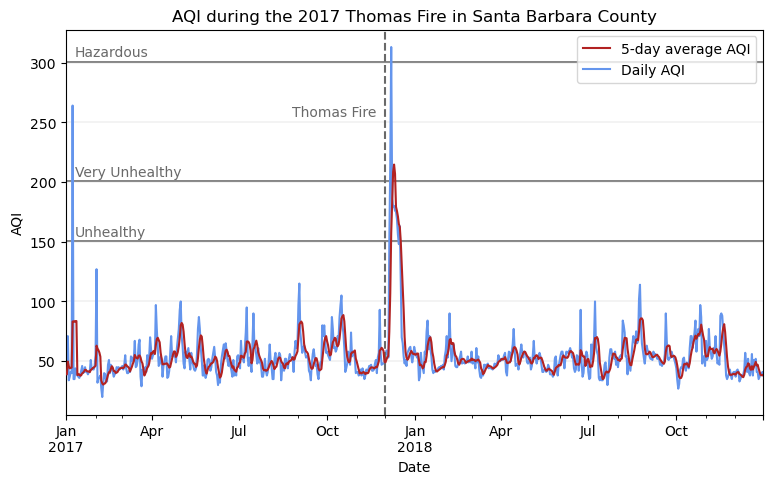

In [8]:
#| code-fold: true
#| code-summary: "Show code for the AQI plot"

# Plot daily AQI against 5-day average ----

# Initialize figure
fig, ax = plt.subplots(figsize=(9,5))

# Add daily and 5-day average AQI
aqi_sb.five_day_average.plot(ax=ax, color = 'firebrick', zorder = 3)
aqi_sb.aqi.plot(ax=ax, color = 'cornflowerblue', zorder = 2)

# Add AQI labels for unhealthy levels
ax.axhspan(150, 151.5, facecolor = "dimgrey", alpha = 0.8)
ax.text(x = pd.to_datetime('2017-01-10'), y = 155, s = 'Unhealthy', color = 'dimgrey')
ax.axhspan(200, 202, facecolor = "dimgrey", alpha = 0.8)
ax.text(x = pd.to_datetime('2017-01-10'), y = 205, s = 'Very Unhealthy', color = 'dimgrey')
ax.axhspan(300, 301, facecolor = "dimgrey", alpha = 0.8)
ax.text(x = pd.to_datetime('2017-01-10'), y = 305, s = 'Hazardous', color = 'dimgrey')

# Update axis labels and title
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('AQI during the 2017 Thomas Fire in Santa Barbara County')

# Add legend
ax.legend(labels = ['5-day average AQI', 'Daily AQI'])

# Add label indicating the Thomas Fire
ax.axvline(x = pd.to_datetime('2017-12-01'), color = 'dimgrey', linestyle = 'dashed')
ax.text(x = pd.to_datetime('2017-08-25'), y = 255, s = 'Thomas Fire', color = 'dimgrey')

# Update grid lines
ax.grid(axis = 'y', linewidth = 0.2)

plt.show()

## Conclusion

For this analysis, I bring my newly aquired skills working with tabular and spatial data in Python together to visualize the impact of the 2017 Thomas Fire on Santa Barbara county. Using false color imagery, I highlight the burn scar. Then, I use daily AQI data to create a plot that accompanies the burn scar map. 